# NPM Transitive Reach — Two Graphs (Runtime vs Runtime+Dev)

In [41]:
# Imports + config
import ast, json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

input_csv       = "c:/Users/gashi/Downloads/top_5000_npm_packages.csv"  # change as needed
out_runtime     = "c:/Users/gashi/Downloads/top500_runtime_only.csv"
out_rundev      = "c:/Users/gashi/Downloads/top500_runtime_plus_dev.csv"
TOP_N           = 500


In [42]:
# Helpers
def _find_pkg_col(df: pd.DataFrame) -> str:
    for cand in ["package", "name", "package_name", "packageName"]:
        if cand in df.columns:
            return cand
    return df.columns[0]

def _parse_list_cell(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, list):
        return [str(s).strip() for s in x if str(s).strip()]
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return []
        for loader in (json.loads, ast.literal_eval):
            try:
                val = loader(s)
                if isinstance(val, (list, tuple)):
                    return [str(t).strip() for t in val if str(t).strip()]
            except Exception:
                pass
        return [t.strip() for t in s.split(",") if t.strip()]
    s = str(x).strip()
    return [s] if s else []


In [43]:
# Build graph utility (edge: pkg -> dependency)
from typing import List

def build_graph(df: pd.DataFrame, include_dev: bool) -> nx.DiGraph:
    pkg_col = _find_pkg_col(df)
    dep_cols: List[str] = []
    if "dependencies_list" in df.columns:
        dep_cols.append("dependencies_list")
    if include_dev and "devDependencies_list" in df.columns:
        dep_cols.append("devDependencies_list")
    if not dep_cols:
        raise KeyError("CSV needs 'dependencies_list' and/or 'devDependencies_list'.")

    G = nx.DiGraph()
    add_node, add_edge = G.add_node, G.add_edge

    for _, row in df.iterrows():
        pkg = str(row[pkg_col]).strip()
        if not pkg:
            continue
        add_node(pkg)
        deps = set()
        for col in dep_cols:
            deps.update(_parse_list_cell(row[col]))
        for dep in deps:
            d = str(dep).strip()
            if d and d != pkg:
                add_edge(pkg, d)
    return G


In [44]:
# Transitive dependents via SCC condensation
def transitive_dependents_via_condensation(G: nx.DiGraph) -> pd.DataFrame:
    if G.number_of_nodes() == 0:
        return pd.DataFrame(columns=["package", "transitive_dependents"])

    sccs = list(nx.strongly_connected_components(G))
    comp_index = {}
    for cid, comp in enumerate(sccs):
        for n in comp:
            comp_index[n] = cid

    C = nx.condensation(G, sccs)
    comp_size = {cid: len(scc) for cid, scc in enumerate(sccs)}

    Cres = C.reverse(copy=True)
    topo = list(nx.topological_sort(Cres))

    acc = {c: 0 for c in Cres.nodes()}
    for c in topo:
        total = 0
        for child in Cres.successors(c):
            total += comp_size[child] + acc[child]
        acc[c] = total

    rows = [(n, acc[comp_index[n]]) for n in G.nodes()]
    df = pd.DataFrame(rows, columns=["package", "transitive_dependents"])
    df = df.sort_values(["transitive_dependents", "package"], ascending=[False, True]).reset_index(drop=True)
    return df


In [45]:
# Load data
df = pd.read_csv(input_csv)
print(f"Loaded {len(df):,} package rows.")


Loaded 5,000 package rows.


In [46]:
# Build both graphs
G_runtime = build_graph(df, include_dev=False)
G_rundev  = build_graph(df, include_dev=True)

print(f"Runtime-only graph: {G_runtime.number_of_nodes():,} nodes, {G_runtime.number_of_edges():,} edges")
print(f"Runtime+Dev graph : {G_rundev.number_of_nodes():,} nodes, {G_rundev.number_of_edges():,} edges")


Runtime-only graph: 6,382 nodes, 12,602 edges
Runtime+Dev graph : 10,562 nodes, 52,924 edges


In [47]:
# Compute rankings and save CSVs
rank_runtime = transitive_dependents_via_condensation(G_runtime)
rank_rundev  = transitive_dependents_via_condensation(G_rundev)

top_runtime = rank_runtime.head(TOP_N)
top_rundev  = rank_rundev.head(TOP_N)

top_runtime.to_csv(out_runtime, index=False)
top_rundev.to_csv(out_rundev, index=False)

print(top_runtime.head(10).to_string(index=False))
print("\n" + top_rundev.head(10).to_string(index=False))
print(f"Saved Top {TOP_N} to: {out_runtime} and {out_rundev}")


       package  transitive_dependents
         tslib                    212
@babel/runtime                    154
         chalk                    122
         debug                    116
        semver                    107
        lodash                     81
   @types/node                     55
          glob                     52
@aws-sdk/types                     51
   graceful-fs                     45

               package  transitive_dependents
            typescript                   2620
           @types/node                   2381
           @babel/core                   2257
           @types/jest                   2232
                  tape                   2227
eslint-config-prettier                   2225
                   ava                   2220
                 tslib                   2209
                    xo                   2208
     @babel/preset-env                   2197
Saved Top 500 to: c:/Users/gashi/Downloads/top500_runtime_only.csv and c:/U

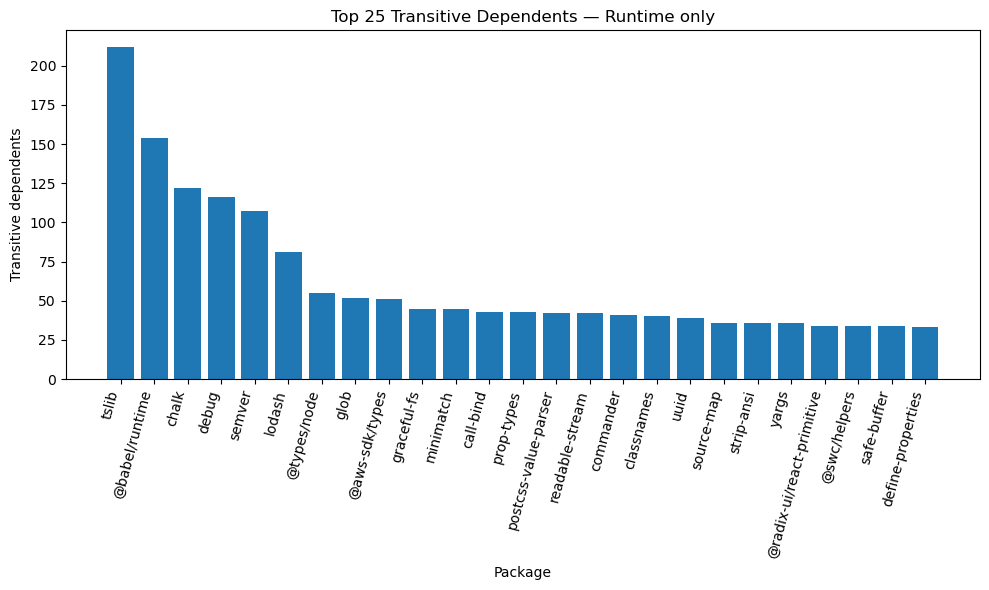

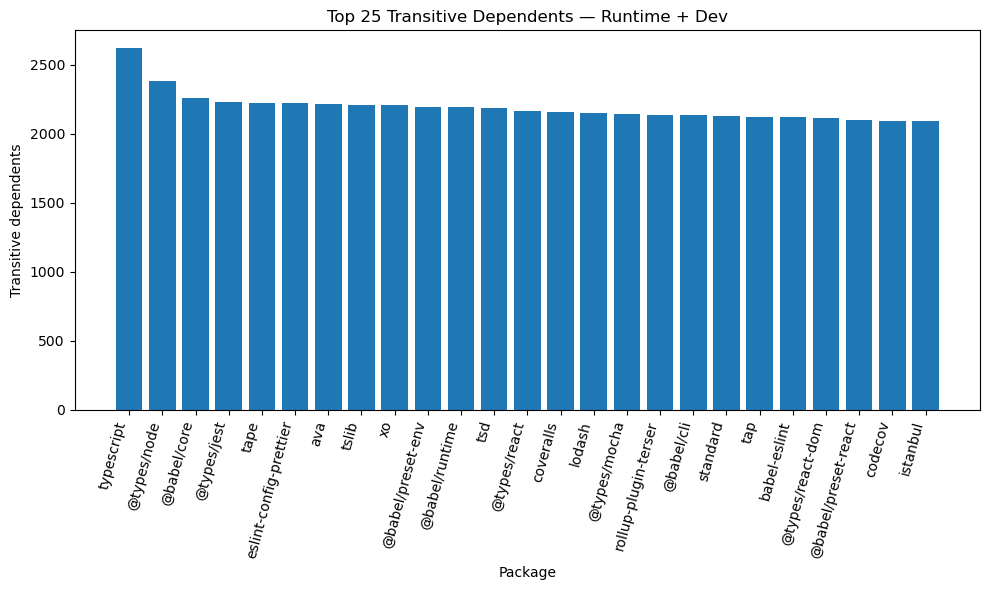

In [48]:
# Plot 1: Top-25 bar chart for each graph (separate plots)
k = 25
tr = top_runtime.head(k).copy()
td = top_rundev.head(k).copy()

plt.figure(figsize=(10, 6))
plt.bar(tr["package"], tr["transitive_dependents"])
plt.xticks(rotation=75, ha="right")
plt.title("Top 25 Transitive Dependents — Runtime only")
plt.xlabel("Package")
plt.ylabel("Transitive dependents")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(td["package"], td["transitive_dependents"])
plt.xticks(rotation=75, ha="right")
plt.title("Top 25 Transitive Dependents — Runtime + Dev")
plt.xlabel("Package")
plt.ylabel("Transitive dependents")
plt.tight_layout()
plt.show()


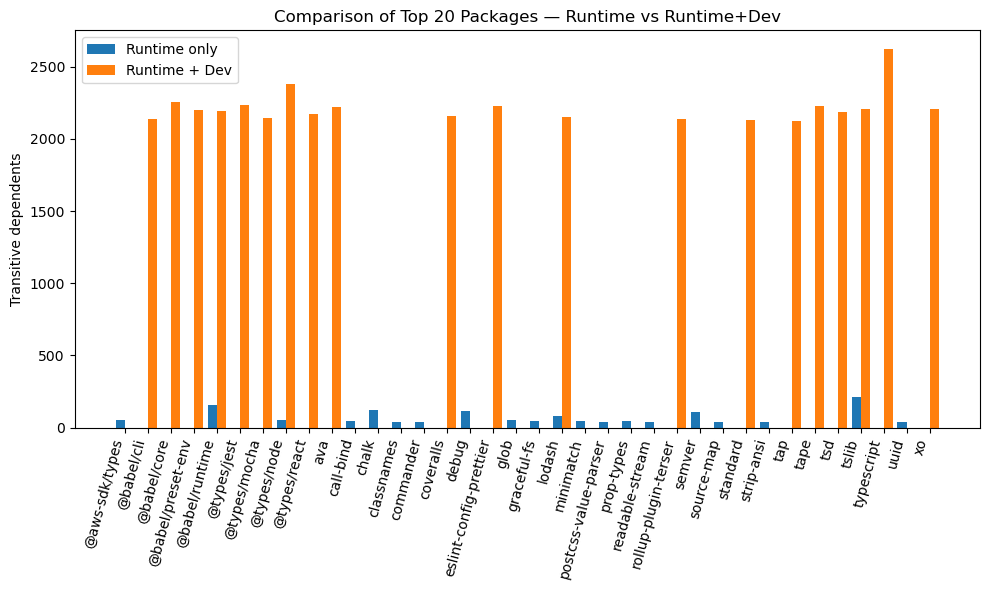

In [49]:
# Plot 2 (replacement): side-by-side bar chart comparing top 20 runtime vs runtime+dev

import matplotlib.pyplot as plt
import numpy as np

# merge top 20 from both graphs
k = 20
r1 = top_runtime.head(k)[["package", "transitive_dependents"]].rename(
    columns={"transitive_dependents": "runtime"}
)
r2 = top_rundev.head(k)[["package", "transitive_dependents"]].rename(
    columns={"transitive_dependents": "runtime_dev"}
)
merged = pd.merge(r1, r2, on="package", how="outer").fillna(0)

x = np.arange(len(merged))
width = 0.4

plt.figure(figsize=(10,6))
plt.bar(x - width/2, merged["runtime"], width, label="Runtime only")
plt.bar(x + width/2, merged["runtime_dev"], width, label="Runtime + Dev")
plt.xticks(x, merged["package"], rotation=75, ha="right")
plt.ylabel("Transitive dependents")
plt.title("Comparison of Top 20 Packages — Runtime vs Runtime+Dev")
plt.legend()
plt.tight_layout()
plt.show()
